## 第四章 神经网络工具箱nn
上一章中提到，使用autograd可实现深度学习模型，但其抽象程度较低，如果用其来实现深度学习模型，则需要编写的代码量极大。在这种情况下，torch.nn应运而生，其是专门为深度学习而设计的模块。torch.nn的核心数据结构是`Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，撰写自己的网络/层。下面先来看看如何用nn.Module实现自己的全连接层。全连接层，又名仿射层，输出$\textbf{y}$和输入$\textbf{x}$满足$\textbf{y=Wx+b}$，$\textbf{W}$和$\textbf{b}$是可学习的参数。

In [1]:
import torch as t
from torch import nn

In [2]:
class Linear(nn.Module): #继承nn.Module
    def __init__(self,in_features,out_features):
        super(Linear,self).__init__() #等价于nn.Module.__init__(self)
        self.w=nn.Parameter(t.randn(in_features,out_features))
        self.b=nn.Parameter(t.randn(out_features))
        
    def forward(self,x):
        x=x.mm(self.w)
        return x+self.b.expand_as(x)
    

In [3]:
layer=Linear(4,3)
inputs=t.randn(2,4)
output=layer(inputs)
output

tensor([[-0.1623, -1.6220, -1.1034],
        [ 0.9342, -0.8809, -0.3743]], grad_fn=<AddBackward0>)

In [4]:
for name,parameter in layer.named_parameters():
    print(name,parameter) #w and b

w Parameter containing:
tensor([[ 0.8296, -0.2411,  0.4088],
        [ 0.1264,  1.8749, -0.5715],
        [ 0.2322,  1.2536, -0.8030],
        [-0.4695, -1.2121, -0.6424]], requires_grad=True)
b Parameter containing:
tensor([ 1.0403, -0.2328, -0.9983], requires_grad=True)


可见，全连接层的实现非常简单，其代码量不超过10行，但需要注意以下几点：

- 自定义层Linear必须继承nn.Module,并且在其构造函数中需要调用nn.Module的构造函数，即`super(Linear, self).__init__()` 或`nn.Module.__init__(self)`，推荐使用第一种用法，尽管第二种写法更直观。
- 在构造函数`__init__`中必须自己定义可学习的参数，并封装成Parameter，如在本例中我们把w和b封装成parameter。parameter是一种特殊的Tensor，但其默认需要求导(`requires_grad=True`)。
- forward函数实现前向传播过程，其输入可以是一个或多个tensor。
- 无需写反向传播函数，`nn.Module`能够利用`autograd`自动实现反向传播，这点比`Function`简单许多。
- 使用时，直观上可将layer看成数学概念中的函数，调用`layer(input)`即可得到input对应的结果。它等价于`layers.__call__(input)`,在__call__函数中，主要调用的是`layer.forward(x)`,另外还对钩子做了一些处理。所以在实际使用中应尽量使用layer(x)而不是使用`layer.forward(x)`,关于钩子技术将在下文中讲解。
- Module中的可学习参数可以通过`named_parameters()`或者`parameters()`返回跌打器，前者会给每个parameter都附上名字，使其更加具有辨识度。

可见利用Module实现的全连接层，比利用Function实现的更为简单，因其不需要再写反向传播函数。

Module能够自动检测到自己的Parameter，并将其作为学习参数。除了parameter之外，Module还包含了子Module，主Module能够递归查找子Module中的parameter。下面再来看看稍微复杂一点的网络，多层感知机。

多层感知机的网络结构如图4-1所示，其由两个全连接层组成，采用sigmoid函数作为激活函数，图中没有画出。

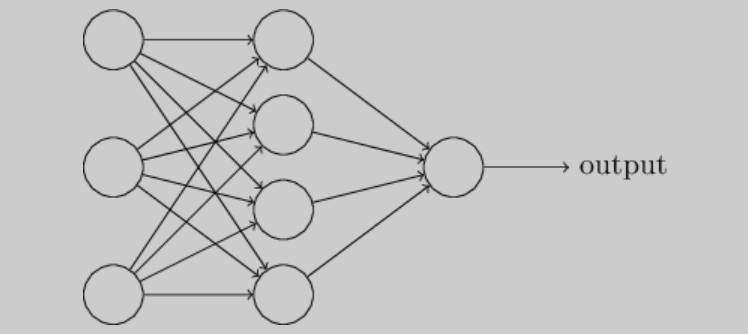

In [5]:
class Perceptron(nn.Module):
    def __init__(self,in_features,hidden_features,out_features):
        nn.Module.__init__(self)
        self.layer1=Linear(in_features,hidden_features)
        self.layer2=Linear(hidden_features,out_features)
        
    def forward(self,x):
        x=self.layer1(x)
        x=t.sigmoid(x)
        return self.layer2(x)

In [6]:
perceptron=Perceptron(3,4,1)
for name,param in perceptron.named_parameters():
    print(name,param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])


可见，即使是稍微复杂的多层感知机，其实现依旧简单。构造函数`__init__`中，可利用前面自定义的Linear层`(Module)`，作为当前module对象的一个子module，它的可学习参数，也会成为当前module的可学习参数。

module中parameter的命名规范：
- 对于类似self.param_name=nn.Parameter(t.randn(3,4)),命名为param_name
- 对于子Module中的parameter，会在其名字之前加上当前Module的名字。对于如self.sub_module=SubModel(),SubModel中有个parameter的名字叫做param_name,那么二者拼接而成的parameter name就是sub_module.param_name.


为方便用户使用，PyTorch实现了神经网络中绝大多数的layer，这些layer都继承于nn.Module，封装了可学习参数`parameter`，并实现了forward函数，且很多都专门针对GPU运算进行了CuDNN优化，其速度和性能都十分优异。本书不准备对nn.Module中的所有层进行详细介绍，具体内容读者可参照官方文档[^1]或在IPython/Jupyter中使用nn.layer?来查看。阅读文档时应主要关注以下几点：

- 构造函数的参数，如nn.Linear(in_features, out_features, bias)，需关注这三个参数的作用。
- 属性、可学习参数和子module。如nn.Linear中有`weight`和`bias`两个可学习参数，不包含子module。
- 输入输出的形状，如nn.linear的输入形状是(N, input_features)，输出为(N，output_features)，N是batch_size。

这些自定义layer对输入形状都有假设：输入的不是单个数据，而是一个batch。输入只有一个数据，则必须调用`tensor.unsqueeze(0)` 或 `tensor[None]`将数据伪装成batch_size=1的batch

[^1]: http://pytorch.org/docs/nn.html

下面将从应用层面出发，对一些常用的layer做简单介绍，更详细的用法请查看文档，这里只做概览参考

### 4.1 常用神经网络
#### 4.1.1 图像相关层

图像相关层主要包括卷积层(Conv),池化层(Pool)等，这些层在实际使用中可分为一维(1D),二维(2D),三维(3D),池化方式又分为平均池化(AvgPool),最大池化(MaxPool),自适应池化(AdaptiveAvgPool)等。而卷积层除了常用的前向卷积之外，还有逆卷积(TransposeConv).下面举例说明一些基础的使用。

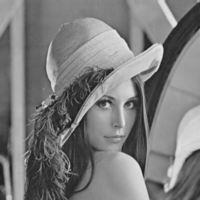

In [7]:
from PIL import Image
from torchvision.transforms import ToTensor,ToPILImage
to_tensor=ToTensor() #img -> tensor
to_pil=ToPILImage()
lena=Image.open("imgs/lena.png")
lena

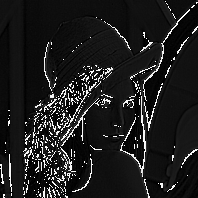

In [8]:
#输入是一个batch，batch_size=1
inputs=to_tensor(lena).unsqueeze(0)

#锐化卷积核
kernel=t.ones(3,3)/(-9.)
kernel[1][1]=1
conv=nn.Conv2d(1,1,(3,3),1,bias=False)
conv.weight.data=kernel.view(1,1,3,3)

out=conv(inputs)
to_pil(out.data.squeeze(0))

除了上述的使用，图像的卷积操作还有各种变体，具体可以参照此处动图[^2]介绍

[^2]: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

池化层可以看做是一种特殊的卷积层，用来下采样。但池化层没有可学习参数，其weight是固定的。

In [9]:
pool=nn.AvgPool2d(2,2)
list(pool.parameters())

[]

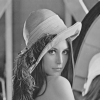

In [10]:
out=pool(inputs)
to_pil(out.data.squeeze(0))

除了卷积层和池化层，深度学习中还将常用到以下几个层：
- Linear:全连接层
- BatchNorm：批规范化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用的InstanceNorm层。
- Dropout: dropout层，用来防止过拟合，同样分为1D、2D和3D。下面通过例子来说明它们的使用。

In [11]:
#输入 batch_size=2,维度为3
inputs=t.randn(2,3)
linear=nn.Linear(3,4)
h=linear(inputs)
h

tensor([[ 1.1125, -0.7339,  0.5550,  1.0918],
        [-0.3376, -0.1051,  1.0430, -0.5296]], grad_fn=<AddmmBackward>)

In [12]:
# 4 channel,初始化标准差为4，均值为0
bn=nn.BatchNorm1d(4)
bn.weight.data=t.ones(4)*4
bn.bias.data=t.zeros(4)

bn_out=bn(h)

#注意输出的均值和方差
#方差是标准差的平方，计算无偏方差分母会减一
#使用unbiased=False 分母不减1
bn_out.mean(0),bn_out.var(0,unbiased=False)

(tensor([0., 0., 0., 0.], grad_fn=<MeanBackward2>),
 tensor([15.9997, 15.9984, 15.9973, 15.9998], grad_fn=<VarBackward1>))

In [13]:
#每个元素以0.5的概率舍弃
dropout=nn.Dropout(0.5)
o=dropout(bn_out)
o #有一半左右的数变为0

tensor([[ 7.9999, -7.9996, -0.0000,  0.0000],
        [-0.0000,  7.9996,  7.9993, -7.9999]], grad_fn=<MulBackward0>)

以上很多例子中都对module的属性直接操作，其大多数是可学习参数，一般会随着学习的进行而不断改变，实际使用中除非需要使用特殊的初始化，应尽量不要直接修改这些参数。

#### 4.1.2 激活函数

Pytorch实现了常见的激活函数，其具体的接口信息可参见官方文档[^3],这些激活函数可作为独立的layer使用。这里讲介绍最常用的激活函数ReLU，其数学表达式：
$$ReLU(x)=max(0,x)$$
[^3]: http://pytorch.org/docs/nn.html#non-linear-activations

In [14]:
relu=nn.ReLU(inplace=True)
imputs=t.randn(2,3)
print(imputs)
output=relu(imputs)
print(output) #小于0的都被截断了
#等价于input.clamp(min=0)

tensor([[ 1.5164,  0.5002,  0.3855],
        [-0.3355, -0.8212, -0.5115]])
tensor([[1.5164, 0.5002, 0.3855],
        [0.0000, 0.0000, 0.0000]])


ReLU函数有个inplace参数，如果设置为TRUE，他会把输出直接覆盖到输入中，这样可以节省内存/显存。之所以可以覆盖是因为在计算ReLU的反向传播时，只需要根据输出就能够推算出反向传播的梯度。但是只是少数的autograd操作支持inplace操作(如tensor.sigmoid()),除非你明确地知道自己在做什么，否则一般不要用inplace操作。

在以上的例子中，基本上都是将每一层的输出直接作为下一层的输入，这种网路称之为前馈传播网络。对于此类网路如果每次都写复杂的forward函数会有些麻烦，在此就有两种简化方式，ModuleList和Sequential。其中Sequential是一个特殊的module，它包含了几个子Module，前向传播时会将输入一层接一层的传递下去。ModuleList也是一个特殊的module，可以包含几个子module，可以像用list一样使用它，但是不能直接把输入传给ModuleList。下面举例说明。

In [15]:
#Sequential的三种写法
net1=nn.Sequential()
net1.add_module("conv",nn.Conv2d(3,3,3))
net1.add_module("batchnorm",nn.BatchNorm2d(3))
net1.add_module("activation_layer",nn.ReLU())

net2=nn.Sequential(nn.Conv2d(3,3,3),
                  nn.BatchNorm2d(3),
                  nn.ReLU())

from collections import OrderedDict

net3=nn.Sequential(OrderedDict([
    ("conv1",nn.Conv2d(3,3,3)),
    ("bn1",nn.BatchNorm2d(3)),
    ("relu",nn.ReLU())
]))

print("net1:",net1)
print("net2:",net2)
print("net3:",net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)


在神经网络进行卷积化处理之后，一般都会使用nn.BatchNorm2d()进行归一化处理，这使得数据在进行ReLU之前，不会进行大的波动。BatchNorm2d()函数数学原理如下：
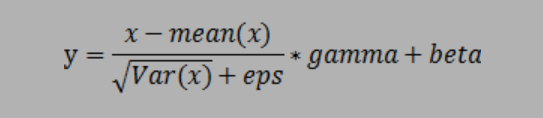

其中的参数有：
- num_features: 一般输入参数为batch_size*num_features*height*width,即为其中特征的数量
- eps: 默认为`1e-5`
- momentum:
- affine: 当设置为true时，会给定可以学习的矩阵gamma和beta

In [16]:
#可根据名字或序号取出子module
net1.conv,net2[0],net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [17]:
imm=t.rand(1,3,4,4)
print(imm)
output=net1(imm)
output=net2(imm)
output=net3(imm)
output=net3.relu(net1.batchnorm(net1.conv(imm)))

tensor([[[[0.0308, 0.4693, 0.8585, 0.9426],
          [0.2103, 0.3804, 0.9202, 0.1384],
          [0.0036, 0.5646, 0.2036, 0.7850],
          [0.8951, 0.5885, 0.4371, 0.2017]],

         [[0.5553, 0.1833, 0.8166, 0.3329],
          [0.4639, 0.8652, 0.7176, 0.4406],
          [0.2145, 0.8353, 0.3112, 0.4657],
          [0.3523, 0.6527, 0.8639, 0.9068]],

         [[0.5312, 0.9431, 0.9056, 0.3839],
          [0.8877, 0.6914, 0.2522, 0.1241],
          [0.1518, 0.4397, 0.3683, 0.7967],
          [0.2468, 0.3005, 0.3446, 0.6008]]]])


In [18]:
output

tensor([[[[0.0000, 1.0904],
          [0.1474, 0.0000]],

         [[0.0000, 0.3803],
          [0.0000, 0.4573]],

         [[0.0000, 0.0000],
          [0.0000, 0.6220]]]], grad_fn=<ReluBackward0>)

In [19]:
modellist=nn.ModuleList([nn.Linear(3,4),nn.ReLU(),nn.Linear(4,2)])
imm=t.randn(1,3)
for model in modellist:
    imm=model(imm)
print(imm)

tensor([[-0.6377,  0.4821]], grad_fn=<AddmmBackward>)


ModuleList是Module的子类，当在Module中使用它的时候，就能自动识别为子Module

下面举例子说明

In [20]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule,self).__init__()
        self.list=[nn.Linear(3,4),nn.ReLU()]
        self.module_list=nn.ModuleList([nn.Conv2d(3,3,3),nn.ReLU()])
        
    def forward(self):
        pass
model=MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

可见，list中的子module并不能被主module所识别，而ModuleList中的子module能够被主module所识别。这意味着如果用list保存子module，将无法调整期参数，因其未加入到主module参数中。

除`ModuleList`之外还有`ParameterList`,其是一个可以包含多个parameter的类list对象。在实际应用中，使用方式与ModuleList类似。如果在构造函数__init__中用到list、tuple、dict等对象时，一定要思考是否应该用ModuleList或ParameterList代替。

#### 4.1.3 循环神经网络层(RNN)

关于RNN的基础知识，推荐阅读colah的文章[^4]入门.Pytorch中实现了如今最常用的三种RNN：RNN(vanilla RNN),LSTM和GRU。此外还有对应的三种RNNCell。

RNN和RNNCell层的区别在于前者一次能够处理整个序列，而后者一次只处理序列中一个时间点的数据，前者封装更完备更易于使用，后者更具灵活性。实际上RNN层的一种后端实现方式就是调用RNNCell来实现的。
[^4]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [21]:
t.manual_seed(1000)
#输入：batch_size=3,序列长度都是2，序列中每个元素占4维
inputs=t.randn(2,3,4)
#lstm输入向量4维，隐藏元3,1层
lstm=nn.LSTM(4,3,1)
#初始状态：1层，batch_size=3,3个隐藏元
h0=t.randn(1,3,3)
c0=t.randn(1,3,3)
out,hn=lstm(inputs,(h0,c0))
out

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [22]:
t.manual_seed(1000)
inputs=t.randn(2,3,4)
#一个LSTMCell对应的层数只能是一层
lstm=nn.LSTMCell(4,3)
hx=t.randn(3,3)
cx=t.randn(3,3)
out=[]
for i_ in inputs:
    hx,cx=lstm(i_,(hx,cx))
    out.append(hx)
t.stack(out)

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

词向量在自然语言中应用十分普及，Pytorch同样提供了Embedding层

In [23]:
#有4个词，每个词用5维的向量表示
embedding=nn.Embedding(4,5)
#可以用预训练好的词向量初始化embedding
embedding.weight.data=t.arange(0,20).view(4,5)

In [24]:
imm=t.arange(3,0,-1).long()
print(imm)
out=embedding(imm)
out

tensor([3, 2, 1])


tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]], grad_fn=<EmbeddingBackward>)

#### 4.1.4 损失函数

在深度学习中要用到各种各样的损失函数，这些损失函数可看做是一种特殊的layer，PyTorch也将这些损失函数实现为`nn.Module`的子类，然而在实际中通常将这些`loss.function`取出来，和主模型互相独立。详细的loss使用请参考文档[^5],这里以分类中最常用的交叉熵损失为例说明。

[^5]: http://pytorch.org/docs/nn.html#loss-functions

In [25]:
# batch_size=3,计算对应每个类别的分类(只有两个类别)
score=t.randn(3,2)
print(score)
#三个样本分别属于(1,0,1)类，label必须是LongTensor
label=t.Tensor([1,0,1]).long()
print(label)
#loss与普通的layer无差异
criterion=nn.CrossEntropyLoss()
loss=criterion(score,label)
loss

tensor([[ 0.6064, -0.6651],
        [ 0.5229, -1.0081],
        [-0.7637,  1.8778]])
tensor([1, 0, 1])


tensor(0.5944)

### 4.2 优化器

PyTorch将深度学习中常用的优化方法全部封装在torch.optim中，其设计十分灵活，能够很方便的扩展成自定义的优化方法。

所有的优化方法都是继承基类optim.Optimizer,并实现了自己的优化步骤。下面就以最基本的优化方法--随机梯度下降法举例子说明。这里需重点掌握：
- 优化方法的基本使用方法
- 如何对模型的不同部分设置不同的学习率
- 如何调整学习率

In [26]:
#首先定义一个LeNet网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features=nn.Sequential(nn.Conv2d(3,6,5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2),
                                   nn.Conv2d(6,16,5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2)
                                   )
        self.classifier=nn.Sequential(nn.Linear(16*5*5,120),
                                     nn.ReLU(),
                                     nn.Linear(120,84),
                                     nn.ReLU(),
                                     nn.Linear(84,10)
                                     )
    def forward(self,x):
        x=self.features(x)
        x=x.view(-1,16*5*5)
        x=self.classifier(x)
        return x
        
net=Net()

In [27]:
from torch import optim
optimizer=optim.SGD(params=net.parameters(),lr=1)
optimizer.zero_grad()  #梯度清零，等价于net.zero_grad()

imm=t.randn(1,3,32,32)
outs=net(imm)
outs.backward(outs)  #fake backward
optimizer.step()  #执行优化

In [28]:
# 为不同的子网络设置不同的学习率，在finetune中经常用到
# 如果对某个参数不指定学习率，就使用最外层的默认学习率
optimizer=optim.SGD([{"params":net.features.parameters()},#学习率为1e-5
                    {"params":net.classifier.parameters(),"lr":1e-2}],lr=1e-5)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [29]:
net.classifier[3]

ReLU()

In [30]:
#只为两个全连接层设置较大的学习率，其余层的学习率较小
special_layers=nn.ModuleList([net.classifier[0],net.classifier[2]])
special_layers_params=list(map(id,special_layers.parameters()))
base_params=filter(lambda p: id(p) not in special_layers_params,net.parameters())
optimizer=t.optim.SGD([{"params": base_params},
                      {"params": special_layers.parameters(),"lr":0.01}],lr=0.001)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

对于如何调整学习率，主要有两种做法。一种是修改optimizer.param_groups中对应的学习率，另一种是更简单也是较为推荐的做法 -- 新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器(如Adam)，会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

In [31]:
#方法1：调整学习率，新建一个optimizer
old_lr=0.1
optimizer1=optim.SGD([{"params":net.features.parameters()},
                     {"params":net.classifier.parameters(),"lr":old_lr*0.1}],lr=1e-5)

optimizer1

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [32]:
#方法2：调整学习率，手动decay,保存动量

for param_group in optimizer.param_groups:
    param_group["lr"]*=0.1 #学习率为之前的0.1倍

optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 4.3 nn.functional

nn中还有一个很常用的模块：`nn.functional`，nn中的大多数layer，在`functional`中都有一个与之相对应的函数。`nn.functional`中的函数和`nn.Module`的主要区别在于，用nn.Module实现的layers是一个特殊的类，都是由`class layer(nn.Module)`定义，会自动提取可学习的参数。而`nn.functional`中的函数更像是纯函数，由`def function(input)`定义。下面举例说明functional的使用，并指出二者的不同之处。

In [33]:
imm=t.randn(2,3)
model=nn.Linear(3,4)
out1=model(imm)
out2=nn.functional.linear(imm,model.weight,model.bias)
out1==out2

tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]], dtype=torch.uint8)

In [34]:
b=nn.functional.relu(imm)
b2=nn.ReLU()(imm)
b==b2

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.uint8)

此时读者可能会问，应该什么时候使用nn.Module，什么时候使用nn.functional呢？答案很简单，如果模型有可学习的参数，最好用nn.Module，否则既可以使用nn.functional也可以使用nn.Module，二者在性能上没有太大差异，具体的使用取决于个人的喜好。如激活函数（ReLU、sigmoid、tanh），池化（MaxPool）等层由于没有可学习参数，则可以使用对应的functional函数代替，而对于卷积、全连接等具有可学习参数的网络建议使用nn.Module。下面举例说明，如何在模型中搭配使用nn.Module和nn.functional。另外虽然dropout操作也没有可学习操作，但建议还是使用`nn.Dropout`而不是`nn.functional.dropout`，因为dropout在训练和测试两个阶段的行为有所差别，使用`nn.Module`对象能够通过`model.eval`操作加以区分。

In [35]:
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=F.pool(F.relu(self.conv1(x)),2)
        x=F.pool(F.relu(self.conv2(x)),2)
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

对于不具备可学习参数的层（激活层、池化层等），将它们用函数代替，这样则可以不用放置在构造函数`__init__`中。对于有可学习参数的模块，也可以用functional来代替，只不过实现起来较为繁琐，需要手动定义参数parameter，如前面实现自定义的全连接层，就可将weight和bias两个参数单独拿出来，在构造函数中初始化为parameter。

In [36]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear,self).__init__()
        self.weight=nn.Parameter(t.randn(3,4))
        self.bias=nn.Parameter(t.zeros(3))
        
    def forward(self):
        return F.linear(imm,weight,bias)

关于`nn.functional`的设计初衷，以及它和nn.Module更多的比较说明，可参见[^6]

[^6]: https://discuss.pytorch.org/search?q=nn.functional

### 4.4 初始化策略

在深度学习中，参数的初始化十分重要，良好的初始化能让模型更快收敛，并达到更高的水平，而糟糕的初始化则可能使得模型变得更糟。Pytorch中的`nn.Module`的模块参数都采取了较为合理的初始化策略，因此一般不需要我们进行考虑，当然我们可以用自定义初始化去替代系统的初始化，而在我们使用Parameter时，自定义初始化则尤为重要，因`t.Tensor()`返回的是内存中的随机数，很可能会有极大值，这在实际训练网络中会出现问题。PyTorch中的`nn.init`模块就是为了初始化而设计的，如果某种初始化策略nn.init不提供，用户也可以自定义初始化。

In [37]:
#利用nn.init初始化
from torch.nn import init
linear=nn.Linear(3,4)

t.manual_seed(1)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]], requires_grad=True)

In [38]:
#直接初始化
import math
t.manual_seed(1)

# xavier初始化的计算公式
std=math.sqrt(2)/math.sqrt(7.)
linear.weight.data.normal_(0,std)

tensor([[ 0.3535,  0.1427,  0.0330],
        [ 0.3321, -0.2416, -0.0888],
        [-0.8140,  0.2040, -0.5493],
        [-0.3010, -0.4769, -0.0311]])

In [39]:
#对模型的所有参数进行初始化
for name, params in net.named_parameters():
    if name.find("linear") !=-1:
        # init linear
        params[0]
        params[1]
        
    elif name.find("conv") !=-1:
        pass
    elif name.find("norm") !=-1:
        
        pass      

### 4.5 nn.Module深入分析

如果想要更深入的理解`nn.Module`,究其原理是很有必要的。首先来看看`nn.Module`基类的构造函数：

```python 
def __init__(self):
    self._parameters=OrderedDict()
    self._modules=OrderedDict()
    self._buffers=OrderedDict()
    self._backward_hooks=OrderedDict()
    self._forward_hooks=OrderedDict()
    self.training=True

```

其中每个属性的解释如下：
- `_parameters`：字典，保存用户直接设置的parameter，`self.param1 = nn.Parameter(t.randn(3, 3))`会被检测到，在字典中加入一个key为'param'，value为对应parameter的item。而self.submodule = nn.Linear(3, 4)中的parameter则不会存于此。
- `_modules`：子module，通过`self.submodel = nn.Linear(3, 4)`指定的子module会保存于此。
- `_buffers`：缓存。如batchnorm使用momentum机制，每次前向传播需用到上一次前向传播的结果。
- `_backward_hooks`与`_forward_hooks`：钩子技术，用来提取中间变量，类似variable的hook。
- `training`：BatchNorm与Dropout层在训练阶段和测试阶段中采取的策略不同，通过判断training值来决定前向传播策略。

上述几个属性中，`_parameters`、`_modules`和`_buffers`这三个字典中的键值，都可以通过`self.key`方式获得，效果等价于`self._parameters['key']`.

下面举例说明。

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #等价于self.register_parameter("param1",nn.Parameter(t.randn(3,3)))
        self.param1=nn.Parameter(t.rand(3,3))
        self.submodel1=nn.Linear(3,4)
    
    def forward(self,imm):
        x=self.param1.mm(imm)
        x=self.submodel1(x)
        return x
    
net=Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [41]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [42]:
net._parameters

OrderedDict([('param1',
              Parameter containing:
              tensor([[0.3398, 0.5239, 0.7981],
                      [0.7718, 0.0112, 0.8100],
                      [0.6397, 0.9743, 0.8300]], requires_grad=True))])

In [43]:
net.param1 #net.key

Parameter containing:
tensor([[0.3398, 0.5239, 0.7981],
        [0.7718, 0.0112, 0.8100],
        [0.6397, 0.9743, 0.8300]], requires_grad=True)

In [44]:
for name, param in net.named_parameters():
    print(name,param.size())
    print(param)

param1 torch.Size([3, 3])
Parameter containing:
tensor([[0.3398, 0.5239, 0.7981],
        [0.7718, 0.0112, 0.8100],
        [0.6397, 0.9743, 0.8300]], requires_grad=True)
submodel1.weight torch.Size([4, 3])
Parameter containing:
tensor([[-0.5260, -0.5489, -0.2785],
        [ 0.5070, -0.0962,  0.2471],
        [-0.2683,  0.5665, -0.2443],
        [ 0.4330,  0.0068, -0.3042]], requires_grad=True)
submodel1.bias torch.Size([4])
Parameter containing:
tensor([ 0.2968, -0.3065,  0.1698, -0.1667], requires_grad=True)


In [45]:
for name,submodel in net.named_modules():
    print(name)
    print(submodel)


Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1
Linear(in_features=3, out_features=4, bias=True)


In [46]:
bn=nn.BatchNorm1d(2)
imm=t.rand(3,2)
print(imm)
out=bn(imm)
bn._buffers

tensor([[0.2616, 0.7713],
        [0.3785, 0.9980],
        [0.9008, 0.4766]])


OrderedDict([('running_mean', tensor([0.0514, 0.0749])),
             ('running_var', tensor([0.9116, 0.9068])),
             ('num_batches_tracked', tensor(1))])

nn.Module在实际使用中可能层层嵌套，一个module包含若干个子module，每一个子module又包含了更多的子module。为方便用户访问各个子module，nn.Module实现了很多方法，如函数`children`可以查看直接子module，函数`module`可以查看所有的子module（包括当前module）。与之相对应的还有函数`named_childen`和`named_modules`，其能够在返回module列表的同时返回它们的名字。

In [47]:
iss=t.arange(0,12).view(3,4)
#md=nn.Dropout()
#在训练阶段，会有一半左右的随机数被设置为0
#md(imm)

In [48]:
iss

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [49]:
import torch
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dropout_1 = nn.Dropout(0.5)
        self.dropout_2 = nn.Dropout(0.5)
    def forward(self, input):
        # print(input)
        drop_1 = self.dropout_1(input)
        print(drop_1)
        drop_1 = self.dropout_1(input)
        print(drop_1)
        drop_2 = self.dropout_2(input)
        print(drop_2)

In [50]:
i = torch.rand((5, 5))
m = MyModel()
m.forward(i)

tensor([[0.3325, 0.0000, 0.0000, 0.0000, 1.6495],
        [1.6071, 1.8869, 0.0000, 0.0000, 0.9806],
        [1.1461, 0.0000, 0.2904, 1.5440, 0.7655],
        [0.0000, 1.0570, 1.3283, 0.0000, 1.3636],
        [0.0000, 0.0739, 1.5034, 0.2969, 0.0000]])
tensor([[0.0000, 1.6090, 1.3104, 0.0000, 0.0000],
        [1.6071, 0.0000, 0.4394, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2904, 1.5440, 0.7655],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.4957, 0.0739, 0.0000, 0.0000, 0.2455]])
tensor([[0.0000, 1.6090, 0.0000, 0.0000, 0.0000],
        [1.6071, 0.0000, 0.0000, 0.8354, 0.0000],
        [0.0000, 0.0000, 0.2904, 1.5440, 0.7655],
        [0.0000, 0.0000, 1.3283, 1.2199, 1.3636],
        [1.4957, 0.0739, 1.5034, 0.2969, 0.0000]])


对于batchnorm、dropout、instancenorm等在训练和测试阶段行为差距巨大的层，如果在测试时不将其training值设为True，则可能会有很大影响，这在实际使用中要千万注意。虽然可通过直接设置`training`属性，来将子module设为train和eval模式，但这种方式较为繁琐，因如果一个模型具有多个dropout层，就需要为每个dropout层指定training属性。更为推荐的做法是调用`model.train()`函数，它会将当前module及其子module中的所有training属性都设为True，相应的，`model.eval()`函数会把training属性都设为False。

In [51]:
print(net.training,net.submodel1.training)

True True


In [52]:
net.eval()
net.training,net.submodel1.training

(False, False)

In [53]:
list(net.named_modules())

[('',
  Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )),
 ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

`register_forward_hook`与`register_backward_hook`，这两个函数的功能类似于variable函数的`register_hook`，可在module前向传播或反向传播时注册钩子。每次前向传播执行结束后会执行钩子函数（hook）。前向传播的钩子函数具有如下形式：`hook(module, input, output) -> None`，而反向传播则具有如下形式：`hook(module, grad_input, grad_output) -> Tensor or None`。钩子函数不应修改输入和输出，并且在使用后应及时删除，以避免每次都运行钩子增加运行负载。钩子函数主要用在获取某些中间结果的情景，如中间某一层的输出或某一层的梯度。这些结果本应写在forward函数中，但如果在forward函数中专门加上这些处理，可能会使处理逻辑比较复杂，这时候使用钩子技术就更合适一些。下面考虑一种场景，有一个预训练好的模型，需要提取模型的某一层（不是最后一层）的输出作为特征进行分类，但又不希望修改其原有的模型定义文件，这时就可以利用钩子函数。下面给出实现的伪代码。


```python
model=VGG()
features=t.Tensor()
def hook(module,imm,out):
    '''把这层的输出拷贝到features中'''
    features.copy_(out.data)
    
    
handle=model.layer8.register_forward_hook(hook)
_=model(imm)
#用完hook后删除
handle.remove()

```

`nn.Module`对象在构造函数中的行为看起来有些怪异，如果想要真正掌握其原理，就需要看两个魔法方法`__getattr__`和`__setattr__`。在Python中有两个常用的buildin方法`getattr`和`setattr`，`getattr(obj, 'attr1')`等价于`obj.attr`，如果`getattr`函数无法找到所需属性，Python会转而调用`obj.__getattr__('attr1')`方法，即`getattr`函数无法找到的交给`__getattr__`函数处理，没有实现`__getattr__`或者`__getattr__`也无法处理的就会raise AttributeError。`setattr(obj, 'name', value)`等价于`obj.name=value`，如果obj对象实现了`__setattr__`方法，setattr会直接调用`obj.__setattr__('name', value)`，否则调用buildin方法。总结一下：
- result  = obj.name会调用buildin函数`getattr(obj, 'name')`，如果该属性找不到，会调用`obj.__getattr__('name')`
- obj.name = value会调用buildin函数`setattr(obj, 'name', value)`，如果obj对象实现了`__setattr__`方法，`setattr`会直接调用`obj.__setattr__('name', value')`

nn.Module实现了自定义的`__setattr__`函数，当执行`module.name=value`时，会在`__setattr__`中判断value是否为`Parameter`或`nn.Module`对象，如果是则将这些对象加到`_parameters`和`_modules`两个字典中，而如果是其它类型的对象，如`Variable`、`list`、`dict`等，则调用默认的操作，将这个值保存在`__dict__`中。

In [54]:
module=nn.Module()
module.param=nn.Parameter(t.ones(2,2))
module._parameters

OrderedDict([('param',
              Parameter containing:
              tensor([[1., 1.],
                      [1., 1.]], requires_grad=True))])

In [55]:
submodule1=nn.Linear(2,2)
submodule2=nn.Linear(2,2)
module_list=[submodule1,submodule2]
#对于list对象，调用buildin函数,保存在__dict__中
module.submodules=module_list

In [56]:
print("_modules:",module._modules)
print("__dict__['submodules']:",module.__dict__.get("submodules"))

_modules: OrderedDict()
__dict__['submodules']: [Linear(in_features=2, out_features=2, bias=True), Linear(in_features=2, out_features=2, bias=True)]


In [57]:
module_list=nn.ModuleList(module_list)
module.submodules=module_list
print("ModuleList is instance of nn.Module:", isinstance(module_list,nn.Module))
print("_modules:",module._modules)
print("__dict__['submodules']:",module.__dict__.get("submodules"))

ModuleList is instance of nn.Module: True
_modules: OrderedDict([('submodules', ModuleList(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
))])
__dict__['submodules']: None


因`_modules`和`_parameters`中的item未保存在`__dict__`中，所以默认的getattr方法无法获取它，因而`nn.Module`实现了自定义的`__getattr__`方法，如果默认的`getattr`无法处理，就调用自定义的`__getattr__`方法，尝试从`_modules`、`_parameters`和`_buffers`这三个字典中获取。

In [58]:
getattr(module,"training")

True

In [59]:
#module.__getattr__("training")
#error

In [60]:
module.attr1=2
getattr(module,"attr1")

2

In [61]:
#报错
#module.__getattr__("attr1")

In [62]:
#即module.param,会调用module.__getattr__("param")
getattr(module,"param")

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

在PyTorch中保存模型十分简单，所有的Module对象都具有state_dict()函数，返回当前Module所有的状态数据。将这些状态数据保存后，下次使用模型时即可利用`model.load_state_dict()`函数将状态加载进来。优化器（optimizer）也有类似的机制，不过一般并不需要保存优化器的运行状态。

In [63]:
#保存模型
t.save(net.state_dict(),"net.pth")


#加载已保存的模型
net2=Net()
net2.load_state_dict(t.load("net.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

实际上还有另外一种保存方法，但因其严重依赖模型定义方式及文件路径结构等，很容易出问题，因而不建议使用。

In [64]:
t.save(net,"net_all.pth")
net2=t.load("net_all.pth")
net2

d:\miniconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

将Module放在GPU上运行也十分简单，只需两步：
- model = model.cuda()：将模型的所有参数转存到GPU
- input.cuda()：将输入数据也放置到GPU上

至于如何在多个GPU上并行计算，PyTorch也提供了两个函数，可实现简单高效的并行GPU计算
- nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)
- class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

可见二者的参数十分相似，通过`device_ids`参数可以指定在哪些GPU上进行优化，output_device指定输出到哪个GPU上。唯一的不同就在于前者直接利用多GPU并行计算得出结果，而后者则返回一个新的module，能够自动在多GPU上进行并行加速。

```
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

DataParallel并行的方式，是将输入一个batch的数据均分成多份，分别送到对应的GPU进行计算，各个GPU得到的梯度累加。与Module相关的所有数据也都会以浅复制的方式复制多份，在此需要注意，在module中属性应该是只读的。

### 4.6 nn和autograd的关系
nn.Module利用的也是autograd技术，其主要工作是实现前向传播。在forward函数中，nn.Module对输入的tensor进行的各种操作，本质上都是用到了autograd技术。这里需要对比autograd.Function和nn.Module之间的区别：
- autograd.Function利用了Tensor对autograd技术的扩展，为autograd实现了新的运算op，不仅要实现前向传播还要手动实现反向传播
- nn.Module利用了autograd技术，对nn的功能进行扩展，实现了深度学习中更多的层。只需实现前向传播功能，autograd即会自动实现反向传播
- nn.functional是一些autograd操作的集合，是经过封装的函数

作为两大类扩充PyTorch接口的方法，我们在实际使用中应该如何选择呢？如果某一个操作，在autograd中尚未支持，那么只能实现Function接口对应的前向传播和反向传播。如果某些时候利用autograd接口比较复杂，则可以利用Function将多个操作聚合，实现优化，正如第三章所实现的`Sigmoid`一样，比直接利用autograd低级别的操作要快。而如果只是想在深度学习中增加某一层，使用nn.Module进行封装则更为简单高效。

### 4.7 小试牛刀：搭建ResNet
Kaiming He的深度残差网络（ResNet）[^7]在深度学习的发展中起到了很重要的作用，ResNet不仅一举拿下了当年CV下多个比赛项目的冠军，更重要的是这一结构解决了训练极深网络时的梯度消失问题。

首先来看看ResNet的网络结构，这里选取的是ResNet的一个变种：ResNet34。ResNet的网络结构如图4-2所示，可见除了最开始的卷积池化和最后的池化全连接之外，网络中有很多结构相似的单元，这些重复单元的共同点就是有个跨层直连的shortcut。ResNet中将一个跨层直连的单元称为Residual block，其结构如图4-3所示，左边部分是普通的卷积网络结构，右边是直连，但如果输入和输出的通道数不一致，或其步长不为1，那么就需要有一个专门的单元将二者转成一致，使其可以相加。

另外我们可以发现Residual block的大小也是有规律的，在最开始的pool之后有连续的几个一模一样的Residual block单元，这些单元的通道数一样，在这里我们将这几个拥有多个Residual block单元的结构称之为layer，注意和之前讲的layer区分开来，这里的layer是几个层的集合。

考虑到Residual block和layer出现了多次，我们可以把它们实现为一个子Module或函数。这里我们将Residual block实现为一个子moduke，而将layer实现为一个函数。下面是实现代码，规律总结如下：

- 对于模型中的重复部分，实现为子module或用函数生成相应的module`make_layer`
- nn.Module和nn.Functional结合使用
- 尽量使用`nn.Seqential`
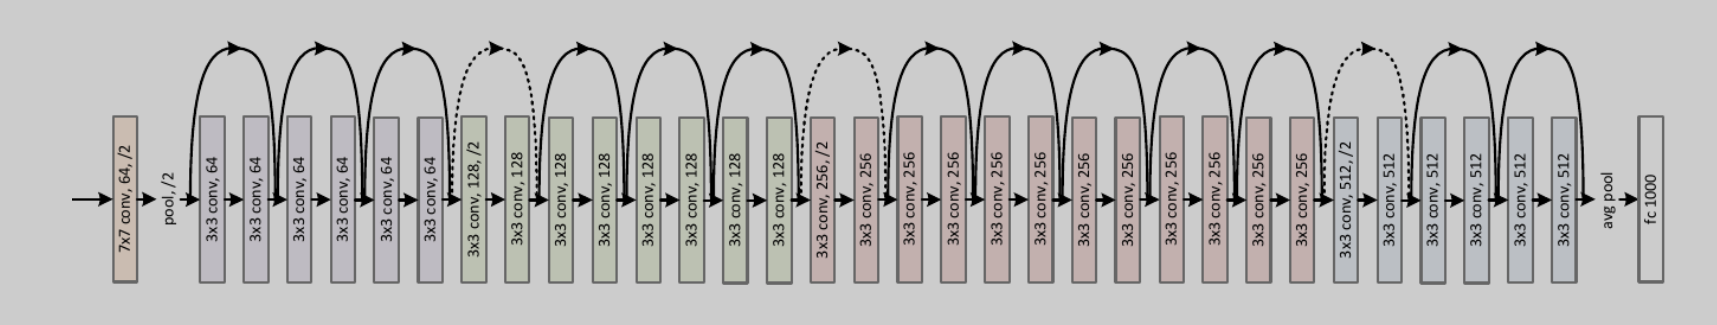

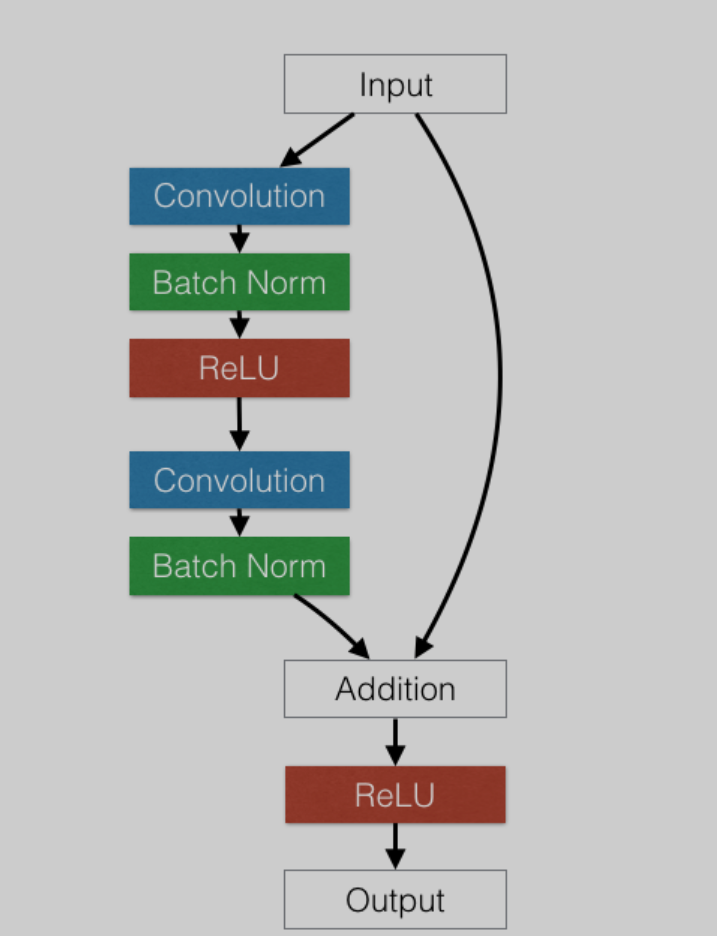

 [^7]: He K, Zhang X, Ren S, et al. Deep residual learning for image recognition[C]//Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016: 770-778.
 
 知乎讲解特别清楚的文章[^8]
 [^8]:https://zhuanlan.zhihu.com/p/67860570

In [65]:
from torch import nn
import torch as t
from torch.nn import functional as F

In [70]:
class ResidualBlock(nn.Module):
    '''
    实现子module： Residual Block
    '''
    def __init__(self,inchannel,outchannel,stride=1,shortcut=None):
        super(ResidualBlock,self).__init__()
        self.left=nn.Sequential(
                        nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
                        nn.BatchNorm2d(outchannel),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                        nn.BatchNorm2d(outchannel))
        self.right=shortcut
        
    def forward(self,x):
        out=self.left(x)
        residual=x if self.right is None else self.right(x)
        out+=residual
        return F.relu(out)
    
    
class ResNet(nn.Module):
    '''
    实现主module：ResNet34
    ResNet34 包含多个layer，每个layer又包含多个residual block
    用子module来实现residual block，用_make_layer来实现layer
    '''
    def __init__(self,num_classes=1000):
        super(ResNet,self).__init__()
        #前几层图像转化
        self.pre=nn.Sequential(nn.Conv2d(3,64,7,2,3,bias=True),  #padding=3代表加了三圈0
                              nn.BatchNorm2d(64),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(3,2,1)) #三个参数分别是第一个是池化层的卷积核大小，第二个是步长，第三个是加0的圈数
        
        
        #重复的layer，分别有3,4,6,3个residual block
        self.layer1=self._make_layer(64,64,3)
        self.layer2=self._make_layer(64,128,4,stride=2)
        self.layer3=self._make_layer(128,256,6,stride=2)
        self.layer4=self._make_layer(256,512,3,stride=2)
        
        #分类用的全连接
        self.fc=nn.Linear(512,num_classes)
        
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        '''
        构建layer,包含多个residual block
        '''
        shortcut=nn.Sequential(nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                              nn.BatchNorm2d(outchannel))
        
        layers=[]
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        
        return nn.Sequential(*layers)  #遇到list必须用*进行转化
    
    
    def forward(self,x):
        x=self.pre(x)
        
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=F.avg_pool2d(x,7)
        x=x.view(x.size(0),-1)
        return self.fc(x)
    

In [71]:
model=ResNet()
imm=t.randn(1,3,224,224)
o=model(imm)

In [74]:
o.shape

torch.Size([1, 1000])

感兴趣的读者可以尝试实现Google的Inception网络结构或ResNet的其它变体，看看如何能够简洁明了地实现它，实现代码尽量控制在80行以内（本例去掉空行和注释总共不超过50行）。另外，与PyTorch配套的图像工具包`torchvision`已经实现了深度学习中大多数经典的模型，其中就包括ResNet34，读者可以通过下面两行代码使用：
```python
from torchvision import models
model = models.resnet34()
```
本例中ResNet34的实现就是参考了torchvision中的实现并做了简化，感兴趣的读者可以阅读相应的源码，比较这里的实现和torchvision中实现的不同。